In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

class HopfieldEnergyNet(nn.Module):
    def __init__(self, num_neurons):
        super().__init__()
        self.num_neurons = num_neurons
        self.weights = nn.Parameter(torch.zeros(num_neurons, num_neurons))  # Symmetric, learnable
        self.bias = nn.Parameter(torch.zeros(num_neurons))  # For flexibility

    def energy(self, states):
        # E = -0.5 * s^T W s - b^T s (batch-averaged)
        interaction = torch.bmm(states.unsqueeze(1), torch.matmul(states, self.weights.transpose(-2, -1)).unsqueeze(2)).squeeze()
        bias_term = torch.matmul(states, self.bias)
        return -0.5 * interaction.mean() - bias_term.mean()

    def forward(self, init_states, steps=10, beta=1.0):
        # Relaxation: Iterative update to minimize energy (continuous, stochastic for exploration)
        states = init_states.clone()  # batch x num_neurons
        for _ in range(steps):
            activation = torch.matmul(states, self.weights) + self.bias
            states = torch.tanh(beta * activation)  # Soft update; beta controls sharpness
            states += 0.01 * torch.randn_like(states)  # Noise for escaping local minima
        return states

# Setup for multi-task: Patterns as desired states (e.g., inputs + outputs encoded)
num_neurons = 20  # Pool for clusters
net = HopfieldEnergyNet(num_neurons)
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Toy patterns: Encode XOR/AND as binary states in specific neurons
# E.g., neurons 0-1: inputs, 2: XOR out; 3-4: inputs, 5: AND out; rest intermediaries (init to 0)
xor_patterns = torch.tensor([
    [1., 1., -1., 0., 0., 0.] + [0.] * 14,  # [in1=1, in2=1, out=-1 (0)]
    [1., -1., 1., 0., 0., 0.] + [0.] * 14,   # [1,0,1]
    [-1., 1., 1., 0., 0., 0.] + [0.] * 14,   # [0,1,1]
    [-1., -1., -1., 0., 0., 0.] + [0.] * 14  # [0,0,0]
])  # batch x num_neurons (sign for binary)
and_patterns = torch.tensor([
    [0., 0., 0., 1., 1., 1.] + [0.] * 14,    # [in3=1, in4=1, out=1]
    [0., 0., 0., 1., -1., -1.] + [0.] * 14,  # [1,0,0]
    [0., 0., 0., -1., 1., -1.] + [0.] * 14,  # [0,1,0]
    [0., 0., 0., -1., -1., -1.] + [0.] * 14  # [0,0,0]
])

# Training: Minimize energy for patterns + L1 sparsity to drop trivial connections
for epoch in range(1000):
    optimizer.zero_grad()
    
    # Compute energy for both tasks
    xor_energy = net.energy(xor_patterns)
    and_energy = net.energy(and_patterns)
    task_energy = xor_energy + and_energy
    
    # Sparsity: L1 on off-diagonal weights
    sparsity_loss = 0.1 * (net.weights - torch.diag(torch.diag(net.weights))).abs().sum()
    
    full_loss = task_energy + sparsity_loss
    full_loss.backward()
    optimizer.step()
    
    # Enforce symmetry (project after update)
    net.weights.data = (net.weights.data + net.weights.data.t()) / 2
    net.weights.data.fill_diagonal_(0)  # No self-loops
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Energy {task_energy.item():.4f}, Sparsity {sparsity_loss.item():.4f}")

# Inference: Inject inputs, relax, read outputs
def infer(inputs, input_neurons, output_neurons, steps=10):
    init_states = torch.zeros(1, num_neurons)
    for i, neuron in enumerate(input_neurons):
        init_states[0, neuron] = inputs[i]
    final_states = net(init_states, steps=steps)
    outputs = final_states[0, output_neurons]
    return torch.sign(outputs)  # Binary decode

# Test XOR
xor_test = torch.tensor([1., 1.])  # Should output -1 (0)
xor_out = infer(xor_test, [0, 1], [2])
print("XOR Output:", xor_out.item())

# Test AND
and_test = torch.tensor([1., 1.])  # Should output 1
and_out = infer(and_test, [3, 4], [5])
print("AND Output:", and_out.item())

/home/lburtle/.pyenv/versions/piml/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


Epoch 0: Energy -0.0000, Sparsity 0.0000
Epoch 200: Energy -2.9741, Sparsity 0.7896
Epoch 400: Energy -5.9688, Sparsity 1.5875
Epoch 600: Energy -8.9661, Sparsity 2.3864
Epoch 800: Energy -11.9643, Sparsity 3.1857
XOR Output: 1.0
AND Output: -1.0


## Better Model

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

class HopfieldEnergyNet(nn.Module):
    def __init__(self, num_neurons):
        super().__init__()
        self.num_neurons = num_neurons
        self.norm = nn.LayerNorm(num_neurons)
        self.weights = nn.Parameter(torch.zeros(num_neurons, num_neurons))
        self.bias = nn.Parameter(torch.zeros(num_neurons))
        nn.init.xavier_uniform_(self.weights)
        self.output_proj = nn.Linear(1, 1)  # Simple output projection for logits

    def energy(self, states):
        interaction = torch.bmm(states.unsqueeze(1), torch.matmul(states, self.weights.transpose(-2, -1)).unsqueeze(2)).squeeze()
        bias_term = torch.matmul(states, self.bias)
        return -0.5 * interaction.mean() - bias_term.mean()

    def forward(self, input_neurons, input_values, output_neurons, steps=20, beta=1.0):
        batch_size = input_values.size(0)

        input_signal = torch.zeros(batch_size, self.num_neurons, device=self.weights.device)
        for i, neuron in enumerate(input_neurons):
            input_signal[:, neuron] = input_values[:, i]

        states = torch.zeros(batch_size, self.num_neurons, device=self.weights.device)

        for _ in range(steps):
            activation = torch.matmul(states, self.weights) + self.bias + input_signal
            new_states = torch.tanh(beta * activation)
            states = self.norm(states + new_states)
            states = states + 0.01 * torch.randn_like(states)

        outputs = self.output_proj(states[:, output_neurons].unsqueeze(-1)).squeeze(-1)
        return outputs, states

# Setup
num_neurons = 15
model = HopfieldEnergyNet(num_neurons)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Toy data
xor_inputs = torch.tensor([[-1.,-1.], [-1.,1.], [1.,-1.], [1.,1.]], dtype=torch.float32)
xor_labels = torch.tensor([0., 1., 1., 0.], dtype=torch.float32)
and_inputs = torch.tensor([[-1.,-1.], [-1.,1.], [1.,-1.], [1.,1.]], dtype=torch.float32)
and_labels = torch.tensor([0., 0., 0., 1.], dtype=torch.float32)

xor_in_neurons = [0, 1]
xor_out_neurons = [2]
and_in_neurons = [3, 4]
and_out_neurons = [5]

# Training loop (joint for simplicity)
for epoch in range(4000):
    optimizer.zero_grad()
    xor_outputs, xor_states = model(xor_in_neurons, xor_inputs, xor_out_neurons)
    xor_loss = F.binary_cross_entropy_with_logits(xor_outputs.squeeze(), xor_labels)
    and_outputs, and_states = model(and_in_neurons, and_inputs, and_out_neurons)
    and_loss = F.binary_cross_entropy_with_logits(and_outputs.squeeze(), and_labels)
    task_loss = xor_loss + and_loss
    sparsity_loss = 0.001 * (model.weights.abs().sum())
    full_loss = task_loss + sparsity_loss
    full_loss.backward()
    optimizer.step()
    if epoch % 800 == 0:
        print(f"Epoch {epoch}: XOR Loss {xor_loss.item():.4f}, AND Loss {and_loss.item():.4f}")

# Inference
with torch.no_grad():
    xor_preds, _ = model(xor_in_neurons, xor_inputs, xor_out_neurons)
    and_preds, _ = model(and_in_neurons, and_inputs, and_out_neurons)
    print("XOR Preds:", torch.sigmoid(xor_preds.squeeze()))
    print("AND Preds:", torch.sigmoid(and_preds.squeeze()))

# Visualization (using weight matrix instead of attn_probs)
def get_energy_graph(model, k):
    weight_matrix = model.weights.data.cpu().numpy()
    weight_matrix = (weight_matrix - weight_matrix.min()) / (weight_matrix.max() - weight_matrix.min() + 1e-8)
    G = nx.Graph() # Use your best k
    edges = []
    for i in range(model.num_neurons):
        for j in range(i + 1, model.num_neurons):
            edges.append((i, j, weight_matrix[i, j]))
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:k]
    
    for i in range(model.num_neurons):
        G.add_node(i)
    for i, j, w in edges:
        G.add_edge(i, j, weight=w)
    return G



Epoch 0: XOR Loss 1.0389, AND Loss 1.3863
Epoch 800: XOR Loss 0.2152, AND Loss 0.0070
Epoch 1600: XOR Loss 0.0039, AND Loss 0.0022
Epoch 2400: XOR Loss 0.0017, AND Loss 0.0010
Epoch 3200: XOR Loss 0.0009, AND Loss 0.0007
XOR Preds: tensor([1.9321e-04, 9.9930e-01, 9.9959e-01, 7.1974e-04])
AND Preds: tensor([1.9576e-04, 5.1980e-04, 5.8098e-04, 9.9974e-01])


k=15: Modularity=0.3647, Components=4
k=20: Modularity=0.3457, Components=1
k=25: Modularity=0.3060, Components=1
k=30: Modularity=0.2763, Components=1
k=35: Modularity=0.2350, Components=1
k=40: Modularity=0.1809, Components=1
k=45: Modularity=0.1789, Components=1
k=50: Modularity=0.1388, Components=1
k=55: Modularity=0.1159, Components=1
k=60: Modularity=0.1032, Components=1
k=65: Modularity=0.0774, Components=1
k=70: Modularity=0.0852, Components=1
k=75: Modularity=0.0777, Components=1
k=80: Modularity=0.0503, Components=1
k=85: Modularity=0.0412, Components=1
k=90: Modularity=0.0282, Components=1
k=95: Modularity=0.0203, Components=1
k=100: Modularity=0.0124, Components=1
Best balanced k: 65 (modularity=0.3647)
Detected clusters: {0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 8: 0, 9: 0, 10: 0, 13: 0, 14: 0, 3: 1, 6: 1, 7: 1, 11: 1, 12: 1}


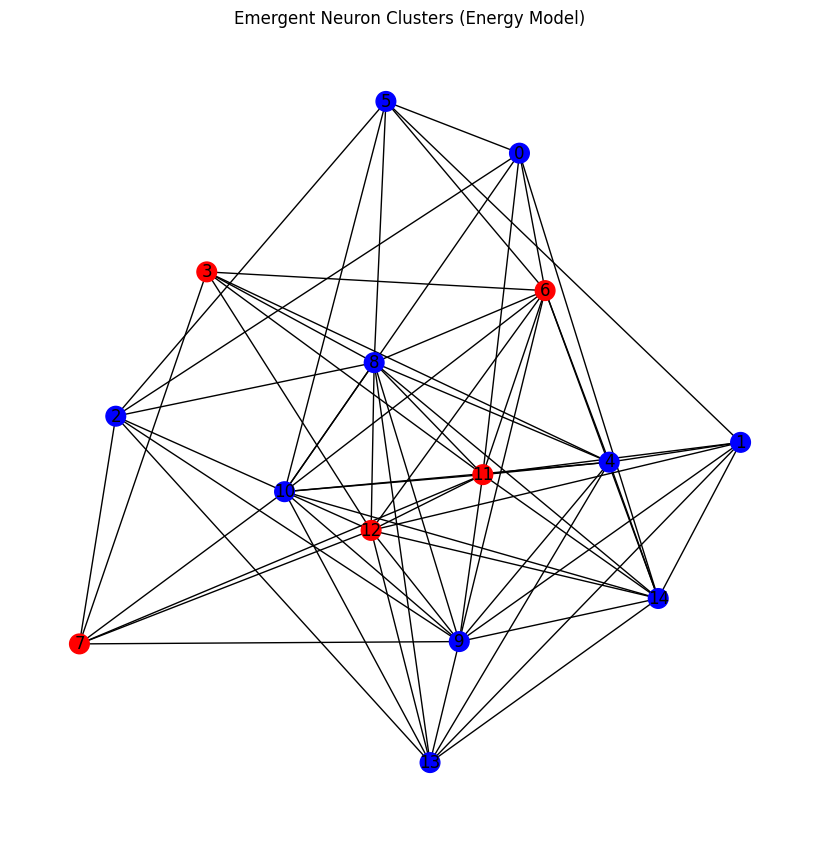

In [33]:
from networkx.algorithms.community import modularity
from kneed import KneeLocator

def find_best_k(model, input_neurons, input_values, output_neurons, min_k=10, max_k=100, step=5, max_components=4):
    k_values = []
    mod_values = []
    for k in range(min_k, max_k + 1, step):
        G = get_energy_graph(model, k=k)
        components = nx.number_connected_components(G)
        communities = greedy_modularity_communities(G, weight='weight')
        current_mod = modularity(G, communities, weight='weight')
        if components <= max_components:  # Filter for connectedness
            k_values.append(k)
            mod_values.append(current_mod)
            print(f"k={k}: Modularity={current_mod:.4f}, Components={components}")
    
    if not k_values:
        print("No valid k found; try increasing max_components")
        return min_k
    
    # Find elbow (knee) in modularity curve
    kneedle = KneeLocator(k_values, mod_values, curve="convex", direction="decreasing")
    best_k = kneedle.knee if kneedle.knee else k_values[np.argmax(mod_values)]
    print(f"Best balanced k: {best_k} (modularity={max(mod_values):.4f})")
    return best_k

best_k = find_best_k(model, xor_in_neurons, xor_inputs, xor_out_neurons)


G = get_energy_graph(model, k=best_k)
pos = nx.spring_layout(G, seed=42)
communities = greedy_modularity_communities(G, weight='weight')
partition = {}
for cluster_id, comm in enumerate(communities):
    for node in comm:
        partition[node] = cluster_id
print("Detected clusters:", partition)

plt.figure(figsize=(8, 8))
colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'gray', 4: 'purple', 5: 'orange'}
node_colors = [colors.get(partition.get(i, 0), 'gray') for i in G.nodes()]
nx.draw(G, pos, node_color=node_colors, node_size=200, with_labels=True)
plt.title("Emergent Neuron Clusters (Energy Model)")
plt.show()

import plotly.graph_objects as go

def visualize_3d(G, pos, partition):
    # Generate 3D positions (use spring_layout with dim=3 or random)
    pos_3d = nx.spring_layout(G, dim=3, seed=42)

    # Edge traces
    edge_x, edge_y, edge_z = [], [], []
    for edge in G.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]

    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(width=2, color='gray'), hoverinfo='none')

    # Node traces
    node_x, node_y, node_z = [], [], []
    node_colors = []
    colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'gray', 4: 'purple', 5: 'orange'}
    for node in G.nodes():
        x, y, z = pos_3d[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_colors.append(colors.get(partition.get(node, 0), 'gray'))

    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers+text', marker=dict(size=10, color=node_colors, opacity=0.8),
                              text=list(G.nodes()), hoverinfo='text')

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title='3D Emergent Neuron Clusters', scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z')))
    fig.show()


# Use the visualize_3d function from earlier for 3D
visualize_3d(G, pos, partition)